# Devide image and finetune vgg16 

## Import modules

In [1]:
import os
import math
import glob
import pytz
import random
import datetime
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter, map_coordinates

## Define global constants

In [2]:
image_dir = '../datasets/pathological_images_JPEG'
label_dir = '../datasets/ndarray_labels'
image_ext = '.jpg'
label_ext = '.npy'
num_partitions_on_each_site = 10
connection_symbol = '^'
model_input_shape = np.array([500, 500, 3])
batch_size = 16
random_seed = 0
validation_ratio = 0.2
num_epochs = 200

## Load sample name list

In [3]:
train_val_sample_names_path = '../datasets/train_val.txt'
test_sample_names_path = '../datasets/test.txt'
train_val_sample_names_file = open(train_val_sample_names_path)
train_val_sample_names = train_val_sample_names_file.read().splitlines()
test_sample_names_file = open(test_sample_names_path)
test_sample_names = test_sample_names_file.read().splitlines()

## Split sample names into training sample names and validation sample names

In [4]:
training_sample_names, validation_sample_names = train_test_split(
    train_val_sample_names,
    test_size=validation_ratio,
    random_state=random_seed
)

## Add suffix that represent position of partition to sample name

In [5]:
# training_sample_name_with_partition_indices = []
# for sample_name in training_sample_names:
#     training_sample_name_with_partition_indices += list(itertools.chain.from_iterable([[sample_name+connection_symbol+str(i)+connection_symbol+str(j) for j in range(num_partitions_on_each_site)] for i in range(num_partitions_on_each_site)]))
# training_sample_name_with_partition_indices

# validation_sample_name_with_partition_indices = []
# for sample_name in validation_sample_names:
#     validation_sample_name_with_partition_indices += list(itertools.chain.from_iterable([[sample_name+connection_symbol+str(i)+connection_symbol+str(j) for j in range(num_partitions_on_each_site)] for i in range(num_partitions_on_each_site)]))

# test_sample_name_with_partition_indices = []
# for sample_name in validation_sample_names:
#     test_sample_name_with_partition_indices += list(itertools.chain.from_iterable([[sample_name+connection_symbol+str(i)+connection_symbol+str(j) for j in range(num_partitions_on_each_site)] for i in range(num_partitions_on_each_site)]))
    
# print(len(training_sample_name_with_partition_indices), len(validation_sample_name_with_partition_indices), len(test_sample_name_with_partition_indices))

In [ ]:
training_sample_name_with_partition_indices = []
for sample_name in tqdm(training_sample_names):
#     image_path = os.path.join(image_dir, sample_name+image_ext)
#     image = Image.open(image_path).resize(num_partitions_on_each_site*model_input_shape[:2])
#     image_array = np.array(image)
    label_array_path = label_dir + '/' + sample_name + label_ext
    label_array = np.load(label_array_path)
    label_image = Image.fromarray(label_array).resize(num_partitions_on_each_site*model_input_shape[:2])
    label_array = np.array(label_image)
    for row_index in range(num_partitions_on_each_site):
        for column_index in range(num_partitions_on_each_site):
#             cropped_image_array = image_array[
#                 row_index*model_input_shape[0]:(row_index+1)*model_input_shape[0],
#                 column_index*model_input_shape[1]:(column_index+1)*model_input_shape[1],
#                 :
#             ]
            cropped_label_array = label_array[
                row_index*model_input_shape[0]:(row_index+1)*model_input_shape[0],
                column_index*model_input_shape[1]:(column_index+1)*model_input_shape[1],
            ]
            if np.sum(cropped_label_array==-1)==0:
                training_sample_name_with_partition_indices.append(sample_name+connection_symbol+str(row_index)+connection_symbol+str(column_index))

validation_sample_name_with_partition_indices = []
for sample_name in tqdm(validation_sample_names):
#     image_path = os.path.join(image_dir, sample_name+image_ext)
#     image = Image.open(image_path).resize(num_partitions_on_each_site*model_input_shape[:2])
#     image_array = np.array(image)
    label_array_path = label_dir + '/' + sample_name + label_ext
    label_array = np.load(label_array_path)
    label_image = Image.fromarray(label_array).resize(num_partitions_on_each_site*model_input_shape[:2])
    label_array = np.array(label_image)
    for row_index in range(num_partitions_on_each_site):
        for column_index in range(num_partitions_on_each_site):
#             cropped_image_array = image_array[
#                 row_index*model_input_shape[0]:(row_index+1)*model_input_shape[0],
#                 column_index*model_input_shape[1]:(column_index+1)*model_input_shape[1],
#                 :
#             ]
            cropped_label_array = label_array[
                row_index*model_input_shape[0]:(row_index+1)*model_input_shape[0],
                column_index*model_input_shape[1]:(column_index+1)*model_input_shape[1],
            ]
            if np.sum(cropped_label_array==-1)==0:
                validation_sample_name_with_partition_indices.append(sample_name+connection_symbol+str(row_index)+connection_symbol+str(column_index))
                    
test_sample_name_with_partition_indices = []
for sample_name in tqdm(test_sample_names):
#     image_path = os.path.join(image_dir, sample_name+image_ext)
#     image = Image.open(image_path).resize(num_partitions_on_each_site*model_input_shape[:2])
#     image_array = np.array(image)
    label_array_path = label_dir + '/' + sample_name + label_ext
    label_array = np.load(label_array_path)
    label_image = Image.fromarray(label_array).resize(num_partitions_on_each_site*model_input_shape[:2])
    label_array = np.array(label_image)
    for row_index in range(num_partitions_on_each_site):
        for column_index in range(num_partitions_on_each_site):
#             cropped_image_array = image_array[
#                 row_index*model_input_shape[0]:(row_index+1)*model_input_shape[0],
#                 column_index*model_input_shape[1]:(column_index+1)*model_input_shape[1],
#                 :
#             ]
            cropped_label_array = label_array[
                row_index*model_input_shape[0]:(row_index+1)*model_input_shape[0],
                column_index*model_input_shape[1]:(column_index+1)*model_input_shape[1],
            ]
            if np.sum(cropped_label_array==-1)==0:
                test_sample_name_with_partition_indices.append(sample_name+connection_symbol+str(row_index)+connection_symbol+str(column_index))

 37%|███▋      | 535/1456 [02:44<04:40,  3.29it/s]

## Create pipelines

### Define function to preprocess data

sample name -> 011-1167_3_N_kubota_2737^3^5


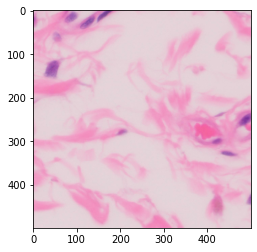

label -> 0


In [11]:
def load_label_array(array_path_tensor):
    array_path = array_path_tensor.numpy()
    label_array = np.load(array_path)
    return label_array

def load_and_preprocess_image(sample_name_with_partition_indices):
    sample_name = tf.strings.split(sample_name_with_partition_indices, connection_symbol)[0]
    row_index = tf.strings.split(sample_name_with_partition_indices, connection_symbol)[1]
    column_index = tf.strings.split(sample_name_with_partition_indices, connection_symbol)[2]
    row_index = int(row_index)
    column_index = int(column_index)
    brightness_max_delta = 0.1
    image_path = image_dir + '/' + sample_name + image_ext
    raw_image = tf.io.read_file(image_path)
    image_tensor = tf.image.decode_jpeg(raw_image)
    image_tensor = tf.image.resize(
        image_tensor, 
        num_partitions_on_each_site*model_input_shape[:2],
        method='nearest'
    )
    image_tensor = image_tensor[
        row_index*model_input_shape[0]:(row_index+1)*model_input_shape[0],
        column_index*model_input_shape[1]:(column_index+1)*model_input_shape[1],
        :
    ]
    image_tensor /= 255
    image_tensor = tf.image.random_flip_left_right(image_tensor, seed=None)
    image_tensor = tf.image.random_flip_up_down(image_tensor, seed=None)
    image_tensor = tf.image.random_brightness(image_tensor, brightness_max_delta)
    label_array_path = label_dir + '/' + sample_name + label_ext
    label_tensor = tf.py_function(func=load_label_array, inp=[label_array_path], Tout=tf.uint8)
    label_tensor = label_tensor[ ..., tf.newaxis]
    label_tensor.set_shape([630,630,1])
    label_tensor = tf.image.resize(label_tensor, num_partitions_on_each_site*model_input_shape[:2])[...,0]
    label_tensor = tf.slice(
        label_tensor, 
        [row_index*model_input_shape[0], column_index*model_input_shape[1]], 
        model_input_shape[:2]
    )
    label = tf.cast(tf.math.reduce_sum(tf.cast(label_tensor==2, tf.int32))>0, tf.int32)
    return image_tensor, label

sample_name_with_partition_index = training_sample_name_with_partition_indices[0]
print('sample name -> {}'.format(sample_name_with_partition_index))
preprocessed_image_tensor, label = load_and_preprocess_image(sample_name_with_partition_index)
plt.imshow(preprocessed_image_tensor)
plt.show()
print('label -> {}'.format(label))

### Create training pipeline

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
num_training_samples = len(training_sample_name_with_partition_indices)
training_sample_name_dataset = tf.data.Dataset.from_tensor_slices(training_sample_name_with_partition_indices)
training_pipeline = (
    training_sample_name_dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
        .cache()
        .apply(tf.data.experimental.shuffle_and_repeat(buffer_size=num_training_samples))
        .batch(batch_size)
        .prefetch(buffer_size=AUTOTUNE)
)
training_steps_per_epoch=tf.math.ceil(num_training_samples/batch_size).numpy()

Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


### Create validation pipeline

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
num_validation_samples = len(validation_sample_name_with_partition_indices)
validation_sample_name_dataset = tf.data.Dataset.from_tensor_slices(validation_sample_name_with_partition_indices)
validation_pipeline = (
    validation_sample_name_dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
        .cache()
        .apply(tf.data.experimental.shuffle_and_repeat(buffer_size=num_validation_samples))
        .batch(batch_size)
        .prefetch(buffer_size=AUTOTUNE)
)
validation_steps_per_epoch=tf.math.ceil(num_validation_samples/batch_size).numpy()

### Create test pipeline

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
num_test_samples = len(test_sample_name_with_partition_indices)
test_sample_name_dataset = tf.data.Dataset.from_tensor_slices(test_sample_name_with_partition_indices)
test_pipeline = (
    test_sample_name_dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
        .cache()
        .batch(batch_size)
        .prefetch(buffer_size=AUTOTUNE)
)

## Create model

In [15]:
input_tensor = tf.keras.Input(shape=model_input_shape)
vgg16 =  tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)
x = vgg16.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs=vgg16.input, outputs=x)

# model.summary()

58892288/58889256 [==============================] - 5s 0us/step


## Compile model

In [21]:
# optimizer = tf.keras.optimizers.Adam(
#     learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
# )
optimizer = tf.keras.optimizers.SGD(lr=0.001)
loss_fn = tf.keras.losses.BinaryCrossentropy()
model.compile(
    loss=loss_fn,
    optimizer=optimizer,
    metrics=['accuracy']
)

## Define callbacks

In [19]:
result_save_dir = './results'
if not os.path.exists(result_save_dir):
    os.mkdir(result_save_dir)
    
current_time = datetime.datetime.now(pytz.timezone('Asia/Tokyo')).isoformat().replace(':', '-')[:16]
current_result_save_dir = './results/{}_size-{}_batch-{}_partition-{}'.format(current_time, model_input_shape[0], batch_size, num_partitions_on_each_site)
if not os.path.exists(current_result_save_dir):
    os.mkdir(current_result_save_dir)


def schedule(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(
    schedule=schedule, 
    verbose=1
)
csv_logging_path = os.path.join(current_result_save_dir,'training.log')
csv_logger = tf.keras.callbacks.CSVLogger(csv_logging_path)
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=5, 
    min_lr=0.000001,
    verbose=1
)
checkpoint_filepath = os.path.join(current_result_save_dir,'model_{val_loss}_{val_accuracy}.h5')
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

callbacks = [
#     learning_rate_scheduler,
#     csv_logger,
    reduce_lr_on_plateau,
#     model_checkpoint,
]

## Train model

In [22]:
history = model.fit(
    training_pipeline, 
    epochs=num_epochs, 
    steps_per_epoch=training_steps_per_epoch, 
    validation_data=validation_pipeline, 
    validation_steps=validation_steps_per_epoch,
    callbacks=callbacks
)

Epoch 1/200
59/59 [==============================] - 26s 444ms/step - loss: 0.7105 - accuracy: 0.5413 - val_loss: 0.7731 - val_accuracy: 0.2500
Epoch 2/200
59/59 [==============================] - 26s 449ms/step - loss: 0.6334 - accuracy: 0.6324 - val_loss: 0.3694 - val_accuracy: 0.9040
Epoch 3/200
59/59 [==============================] - 26s 438ms/step - loss: 0.5445 - accuracy: 0.7511 - val_loss: 0.6914 - val_accuracy: 0.5491
Epoch 4/200
59/59 [==============================] - 26s 436ms/step - loss: 0.4681 - accuracy: 0.7839 - val_loss: 0.3527 - val_accuracy: 0.8772
Epoch 5/200
59/59 [==============================] - 26s 436ms/step - loss: 0.4227 - accuracy: 0.8093 - val_loss: 0.4348 - val_accuracy: 0.7366
Epoch 6/200
59/59 [==============================] - 26s 435ms/step - loss: 0.3719 - accuracy: 0.8496 - val_loss: 0.4626 - val_accuracy: 0.7254
Epoch 7/200
59/59 [==============================] - 26s 441ms/step - loss: 0.3393 - accuracy: 0.8697 - val_loss: 0.1689 - val_accuracy:

KeyboardInterrupt: 

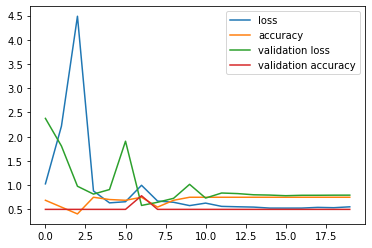

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_accuracy'])
plt.legend(['loss', 'accuracy', 'validation loss', 'validation accuracy'])

## Evaluate model with test samples

In [ ]:
test_resluts = model.evaluate(test_pipeline)
print('test_resluts -> {}'.format(test_resluts))
test_predictions = model.predict(test_pipeline)[:,0]>0.5
test_true_labels = []
for image, label in test_pipeline:
    test_true_labels += [*label.numpy()]
label_dict = {0: 'Normal', 1: 'Tumor'}
test_confusion_matrix = confusion_matrix(
    [label_dict[label] for label in test_true_labels], 
    [label_dict[label] for label in test_predictions]
)
test_confusion_matrix_df = pd.DataFrame(
    test_confusion_matrix, 
    columns=list(label_dict.values()), 
    index=list(label_dict.values())
)
display(test_confusion_matrix_df)
sns.heatmap(test_confusion_matrix, annot=True)
plt.xlabel('Prediction')
plt.ylabel('True')

In [ ]:
test_predictions = model.predict(test_pipeline).flatten() > 0.5
wrong_sample_index = [(test_true_labels[i]-test_prediction)!=False for i, test_prediction in enumerate(test_predictions)]
wrong_sample_index
images = []
for image, label in test_pipeline:
    images += [*image.numpy()]
images = np.array(images)
test_true_labels = np.array(test_true_labels)
for label, image in zip(test_true_labels[wrong_sample_index], images[wrong_sample_index]):
    plt.imshow(image)
    plt.title(label)
    plt.show()